# Semantic Segmentation Using TensorFlow Keras




In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


# Import necessary frameworks, libraries and modules

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
from scipy import io
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt

# Download and prepare data

In [3]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

Cloning into 'clothing-co-parsing'...
remote: Enumerating objects: 4234, done.
remote: Total 4234 (delta 0), reused 0 (delta 0), pack-reused 4234
Receiving objects: 100% (4234/4234), 124.59 MiB | 25.28 MiB/s, done.
Resolving deltas: 100% (1100/1100), done.


In [4]:
!echo $PWD

/kaggle/working


In [5]:
!ls clothing-co-parsing/

LICENSE    annotations	label_list.mat	show_image_anno.m
README.md  example.jpg	photos		show_pixel_anno.m


In [6]:
images = []
for i in range(1,1001):
    url = './clothing-co-parsing/photos/%04d.jpg'%(i)
    img = cv2.imread(url)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(tf.convert_to_tensor(img))

In [7]:
masks = []
for i in range(1,1001):
    url = './clothing-co-parsing/annotations/pixel-level/%04d.mat'%(i)
    file = io.loadmat(url)
    mask = tf.convert_to_tensor(file['groundtruth'])
    masks.append(mask)

In [8]:
len(images), len(masks)

(1000, 1000)

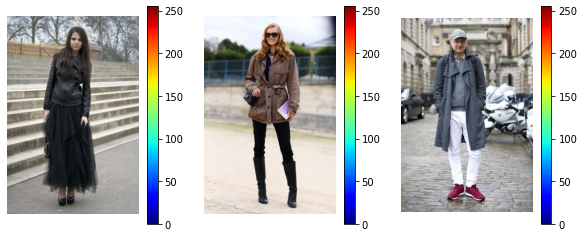

In [9]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

In [10]:
masks[0].numpy().min(), masks[0].numpy().max()

(0, 55)

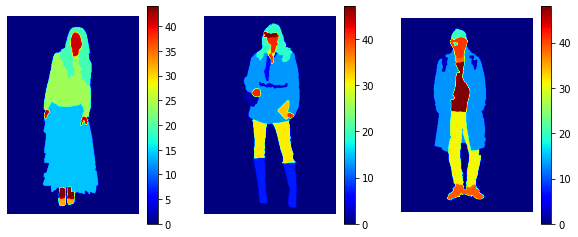

In [11]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

# Build Downstack with a Pre-trained CNN

In [12]:
base = keras.applications.DenseNet121(input_shape=[128,128,3], 
                                      include_top=False, 
                                      weights='imagenet')

29089792/29084464 [==============================] - 0s 0us/step


In [13]:
len(base.layers)

427

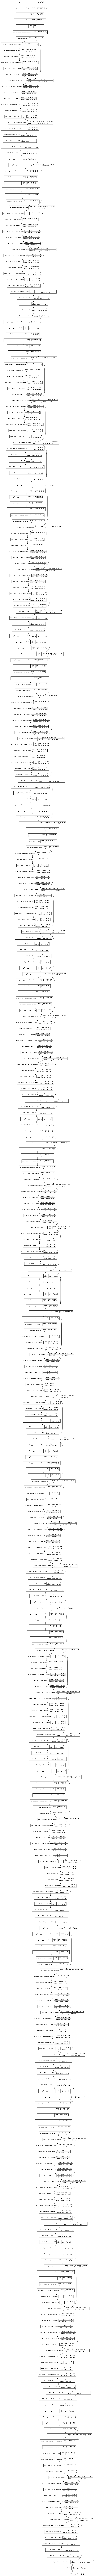

In [44]:
keras.utils.plot_model(base, show_shapes=True)

In [15]:
skip_names = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]

In [16]:
skip_outputs = [base.get_layer(name).output for name in skip_names]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [17]:
downstack = keras.Model(inputs=base.input,
                       outputs=skip_outputs)
downstack.trainable = False

# Build Upstack

In [18]:
# Four upstack layers for upsampling sizes 
# 4->8, 8->16, 16->32, 32->64 
upstack = [pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3),
          pix2pix.upsample(64,3)]

In [19]:
upstack[0].layers

# Build U-Net model with skip-connections

In [20]:
# define the input layer
inputs = keras.layers.Input(shape=[128,128,3])

# downsample 
down = downstack(inputs)
out = down[-1]

# prepare skip-connections
skips = reversed(down[:-1])
# choose the last layer at first 4 --> 8

# upsample with skip-connections
for up, skip in zip(upstack,skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])
    
# define the final transpose conv layer
# image 128 by 128 with 59 classes
out = keras.layers.Conv2DTranspose(59, 3,
                                  strides=2,
                                  padding='same',
                                  )(out)
# complete unet model
unet = keras.Model(inputs=inputs, outputs=out)

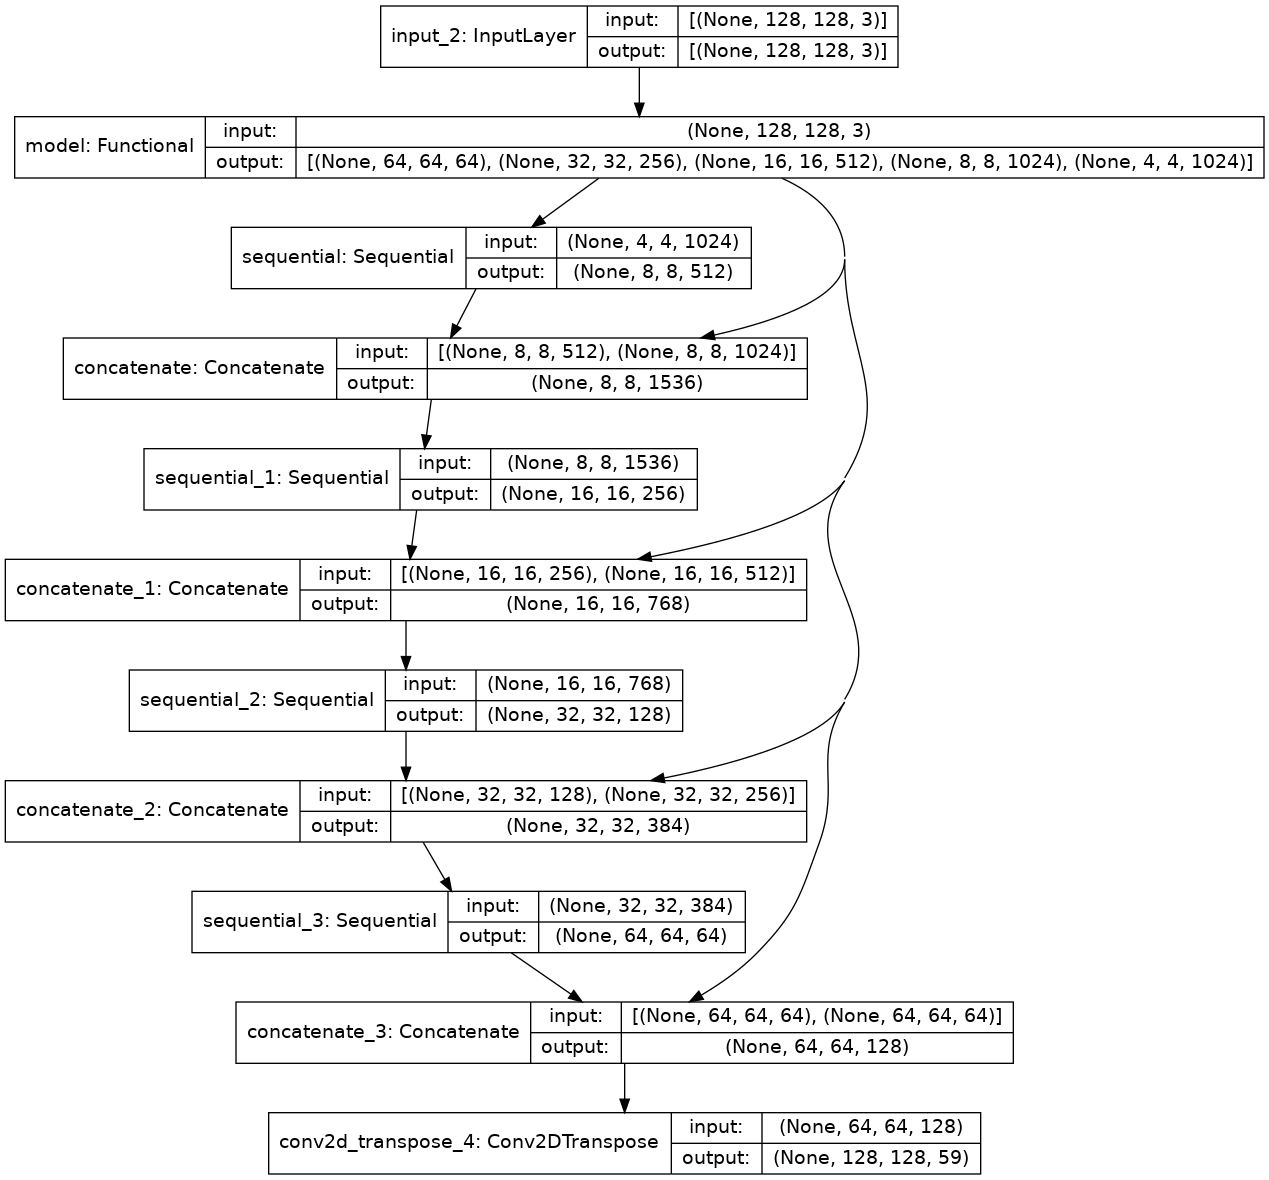

In [21]:
keras.utils.plot_model(unet, show_shapes=True)

# Data Preprocessing

In [23]:
def resize_image(image):
    image = tf.cast(image, tf.float32)
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image

def resize_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask    

In [24]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]
len(X), len(y)

(1000, 1000)

In [25]:
images[0].dtype, masks[0].dtype, X[0].dtype, y[0].dtype

(tf.uint8, tf.uint8, tf.float32, tf.uint8)

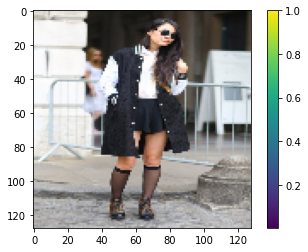

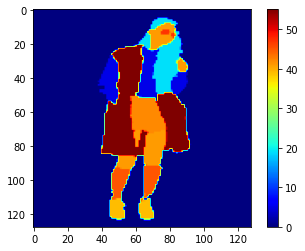

In [26]:
plt.imshow(X[0])
plt.colorbar()
plt.show()

plt.imshow(y[0], cmap='jet')
plt.colorbar()
plt.show()

Functions for augmentation

In [27]:
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

# Split Data for training and validation

In [28]:
from sklearn.model_selection import train_test_split

train_X, val_X,train_y, val_y = train_test_split(X,y, 
                                                      test_size=0.2, 
                                                      random_state=0
                                                     )
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

# Data Augmentation 

In [29]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

# perform augmentation on train data only

a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

In [30]:
BATCH = 64
AT = tf.data.AUTOTUNE
BUFFER = 1000

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

In [31]:
train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

# Check for Model and Data compatibility

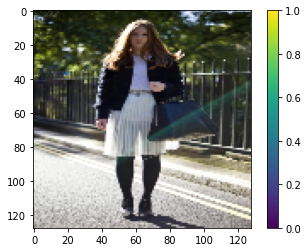

In [32]:
example = next(iter(train))
preds = unet(example[0])
plt.imshow(example[0][60])
plt.colorbar()
plt.show()

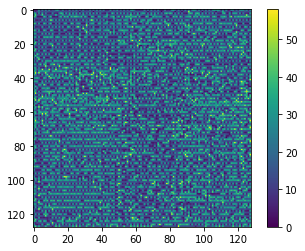

In [33]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0])
plt.colorbar()

In [34]:
unet.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(lr=0.001),
            metrics=['accuracy']) 

# Training

In [35]:
hist = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=50)

Epoch 1/50
12/12 [==============================] - 14s 416ms/step - loss: 3.2440 - accuracy: 0.4331 - val_loss: 3.5278 - val_accuracy: 0.1101
Epoch 2/50
12/12 [==============================] - 2s 193ms/step - loss: 1.7211 - accuracy: 0.7677 - val_loss: 2.8097 - val_accuracy: 0.6584
Epoch 3/50
12/12 [==============================] - 2s 192ms/step - loss: 1.2514 - accuracy: 0.7773 - val_loss: 2.1582 - val_accuracy: 0.7485
Epoch 4/50
12/12 [==============================] - 2s 197ms/step - loss: 1.2346 - accuracy: 0.7364 - val_loss: 1.6511 - val_accuracy: 0.7865
Epoch 5/50
12/12 [==============================] - 2s 194ms/step - loss: 1.2243 - accuracy: 0.7227 - val_loss: 1.3343 - val_accuracy: 0.7941
Epoch 6/50
12/12 [==============================] - 2s 191ms/step - loss: 1.0238 - accuracy: 0.7620 - val_loss: 1.1491 - val_accuracy: 0.7907
Epoch 7/50
12/12 [==============================] - 2s 193ms/step - loss: 0.9117 - accuracy: 0.7829 - val_loss: 1.0312 - val_accuracy: 0.7947
Epoch

# Prediction

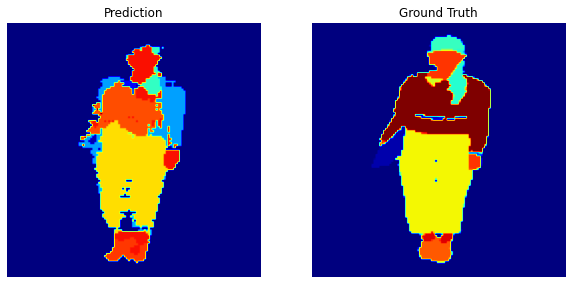

In [40]:
img, mask = next(iter(val))
pred = unet.predict(img)
plt.figure(figsize=(10,5))
for i in pred:
    plt.subplot(121)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')
    break
plt.subplot(122)
plt.imshow(mask[0], cmap='jet')
plt.axis('off')
plt.title('Ground Truth')
plt.show()

# Performance Curves

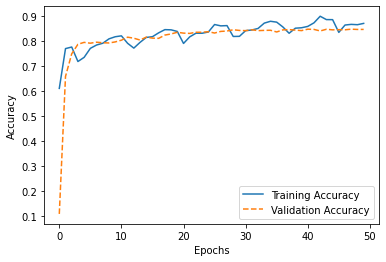

In [43]:
history = hist.history
acc=history['accuracy']
val_acc = history['val_accuracy']

plt.plot(acc, '-', label='Training Accuracy')
plt.plot(val_acc, '--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Thank you for your time!